In [11]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

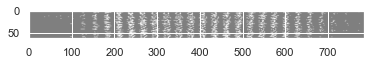

In [14]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip()
])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [15]:
'''
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.covModule = nn.Sequential(
            #input a 3x32x32 image
            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28
            nn.MaxPool2d(2, 2),#image size will be 64x14x14
            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10
            nn.MaxPool2d(2, 2), #image size will be 64x5x5
            nn.Conv2d(64, 128, (5,5)) #image size will be 64x1x1
            #nn.MaxPool2d(2, 2), #image size will be 128x1x1
        )
        self.fcModule = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it
        )
    def forward(self, x):
        x = self.covModule(x)
        x = x.view(-1, 1*1*128)
        output = self.fcModule(x)
        return output
'''



'\nclass ConvNet(nn.Module):\n    def __init__(self):\n        super(ConvNet, self).__init__()\n        self.covModule = nn.Sequential(\n            #input a 3x32x32 image\n            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28\n            nn.MaxPool2d(2, 2),#image size will be 64x14x14\n            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10\n            nn.MaxPool2d(2, 2), #image size will be 64x5x5\n            nn.Conv2d(64, 128, (5,5)) #image size will be 64x1x1\n            #nn.MaxPool2d(2, 2), #image size will be 128x1x1\n        )\n        self.fcModule = nn.Sequential(\n            nn.Linear(128, 128),\n            nn.ReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(128, 10),\n            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it\n        )\n    def forward(self, x):\n        x = self.covModule(x)\n        x = x.view(-1, 1*1*128)\n        output = self.fcModule(x)\n        return output\n'

In [16]:
'''
class alexNet(nn.Module):
    def __init__(self):
        super(alexNet, self).__init__()
        self.alexNet = nn.Sequential([
            nn.Conv2d(kernel_size=(11,11), stride=(4,4), activation='relu', input_shape=(227,227,3), filters=96),
            nn.BatchNormalization(),
            nn.MaxPool2d(pool_size=(3,3), strides=(2,2)),
            nn.Conv2d(filters=256, kernel_size=(5,5), stride=(1,1), activation='relu', padding="same"),
            nn.BatchNormalization(),
            nn.MaxPool2d(pool_size=(3,3), strides=(2,2)),
            nn.Conv2d(filters=384, kernel_size=(3,3), stride=(1,1), activation='relu', padding="same"),
            nn.BatchNormalization(),
            nn.Conv2d(filters=384, kernel_size=(3,3), stride=(1,1), activation='relu', padding="same"),
            nn.BatchNormalization(),
            nn.Conv2d(filters=256, kernel_size=(3,3), stride=(1,1), activation='relu', padding="same"),
            nn.BatchNormalization(),
            nn.MaxPool2d(pool_size=(3,3), stride=(2,2)),
            nn.Flatten(),
            nn.Dense(4096, activation='relu'),
            nn.Dropout(0.5),
            nn.Dense(4096, activation='relu'),
            nn.Dropout(0.5),
            nn.Dense(10, activation='softmax')
        ])
    def forward(self, x):
        x = self.alexNet(x)
        return x


'''

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [17]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [18]:
model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [19]:
loss_history = []
epochs = []
n_total_steps = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    if epoch == 60:
        learning_rate = learning_rate/10
    if epoch == 120:
        learning_rate = learning_rate/10
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())
        epochs.append(epoch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch+1) % 30 == 0:
        plotLosses(epochs, loss_history, 'loss graph for cnn')

print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [96, 3, 11, 11], but got 2-dimensional input of size [64, 784] instead

In [ ]:

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

In [ ]:
trial = torchbearer.Trial(model, optimizer, criterion, metrics=['loss', 'accuracy', 'top_5_acc'])
trial.with_generators(train_loader, test_generator=test_loader)

trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

In [ ]:
print(test_loader.items)

In [ ]:
print(len(epochs))
print(len(loss_history))

In [ ]:
plt.plot(epochs,loss_history)
print(len(train_loader))